In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [26]:
from tensorflow.keras import models, layers

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [2]:
new_dir = "C:\\Users\\VIPIN KUMAR\\Desktop\ml data\\PlantVillage"

In [5]:
datasets = tf.keras.preprocessing.image_dataset_from_directory(
    new_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [6]:
class_names = datasets.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
# we have batch of 32 so if we do 32*501 then we get total images

In [8]:
len(datasets)

501

In [9]:
30*501

15030

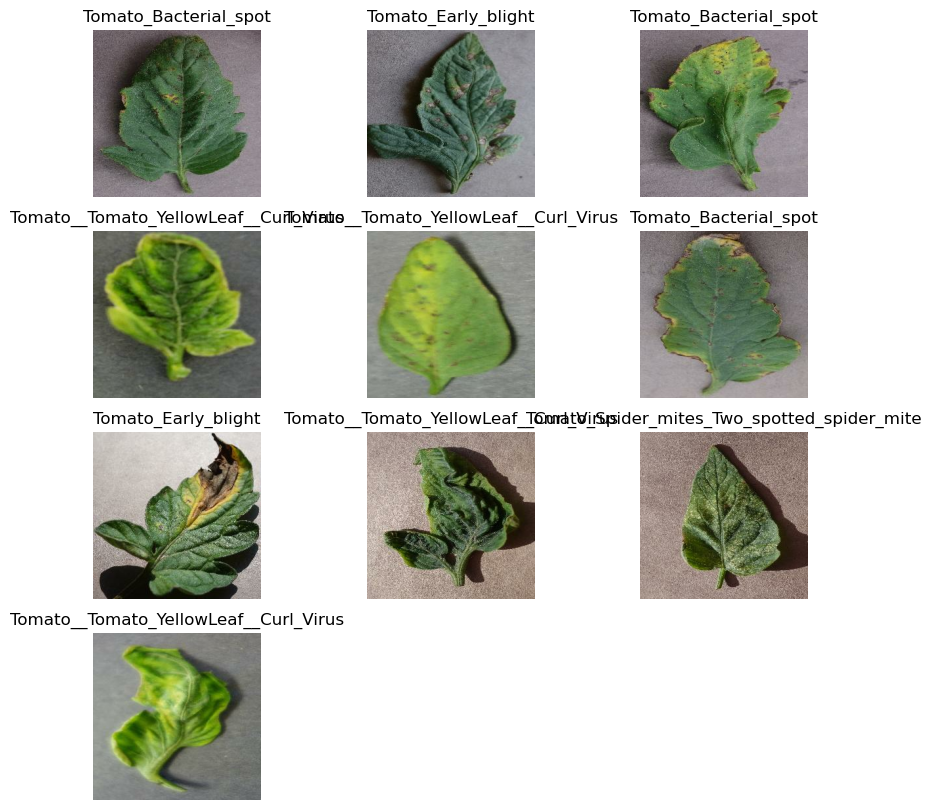

In [10]:
plt.figure(figsize=(10,10))

for batch_img, batch_label in datasets.take(1):
    for i in range(10):
        plt.subplot(4,3,i+1)
        plt.axis('off')
        plt.title(class_names[batch_label[i]])
        plt.imshow(batch_img[i].numpy().astype("uint8"))

In [11]:
len(datasets)

501

In [12]:
501*0.8

400.8

In [13]:
train_ds = datasets.take(400)
len(train_ds)

400

In [14]:
remaining_ds = datasets.skip(400)
len(remaining_ds)

101

In [15]:
validation_ds = remaining_ds.take(51)
len(validation_ds)

51

In [16]:
test_ds = remaining_ds.skip(51)
len(test_ds)

50

In [17]:
def split_data(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 5)
        # seed is for diffent data everytime it can be any number
    train_size = int(train_split*ds_size)
    val_size = int(ds_size*val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds

In [18]:
train_ds, test_ds, validation_ds = split_data(datasets)

In [19]:
len(train_ds)

400

In [20]:
len(test_ds)

51

In [21]:
len(validation_ds)

50

In [22]:
# cache store the image and use it in next iteration if use

train_ds = train_ds.cache().shuffle(900)
test_ds = test_ds.cache().shuffle(900)
validation_ds = validation_ds.cache().shuffle(900)

In [27]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [29]:
model = models.Sequential([
    
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(65, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(65, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(65, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(65, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, 3))

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 65)        18785     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 65)          0         
 g2D)                                                 

In [31]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
model.fit(
    train_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_data=validation_ds
)

Epoch 1/10


400/400 [==============================] - ETA: 0s - loss: 1.4047 - accuracy: 0.5060

In [ ]:
score = model.evaluate(test_ds)

In [ ]:
for images, labels in test_ds.take(1):
    first_img = images[0].numpy().astype("unit8")
    first_label = labels[0].numpy()
    
    plt.imshow(first_img)
    print("actual_: ",first_label)
    
    prediction = model.predict(images)
    print("prediction : "class_names[np.argmax(prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    
    predicted_label = class_names[np.argmax(prediction[0])]
    surity = ((np.max(prediction[0]))*100, 2)
    
    return predicted_label, surity

In [ ]:
for images, labels in test_ds.take(1):
    for i in range(10):
        plt.subpllot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        
        predicted_label, surity = predict(model, images[i].numpy())
        actual = class_names[labels[i]]
        plt.title(f"Actual : {actual}, \n Predicted : {predicted_label}, \n Surity : {surity}%")